In [5]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [6]:
#@title Figure Settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [7]:
# @title Plotting Functions


def plot_cross_validate_MSE(mse_all):
    """ Plot the MSE values for the K_fold cross validation

    Args:
        mse_all (ndarray): an array of size (number of splits, max_order + 1)
    """
    plt.figure()
    plt.boxplot(mse_all, labels=np.arange(0, max_order + 1))

    plt.xlabel('Polynomial Order')
    plt.ylabel('Validation MSE')
    plt.title(f'Validation MSE over {n_splits} splits of the data')
    plt.show()


def plot_AIC(order_list, AIC_list):
    """ Plot the AIC value for fitted polynomials of various orders

    Args:
        order_list (list): list of fitted polynomial orders
        AIC_list (list): list of AIC values corresponding to each polynomial model on order_list
    """
    plt.bar(order_list, AIC_list)
    plt.ylabel('AIC')
    plt.xlabel('polynomial order')
    plt.title('comparing polynomial fits')
    plt.show()

In [8]:
# @title Helper Functions

def ordinary_least_squares(x, y):
    """Ordinary least squares estimator for linear regression.

    Args:
        x (ndarray): design matrix of shape (n_samples, n_regressors)
        y (ndarray): vector of measurements of shape (n_samples)

    Returns:
        ndarray: estimated parameter values of shape (n_regressors)
    """

    return np.linalg.inv(x.T @ x) @ x.T @ y

    
def make_design_matrix(x, order):
    """Create the design matrix of inputs for use in polynomial regression

    Args:
        x (ndarray): input vector of shape (n_samples)
        order (scalar): polynomial regression order

    Returns:
        ndarray: design matrix for polynomial regression of shape (samples, order+1)
    """

    # Broadcast to shape (n x 1)
    if x.ndim == 1:
        x = x[:, None]

    #if x has more than one feature, we don't want multiple columns of ones so we assign
    # x^0 here
    design_matrix = np.ones((x.shape[0], 1))

    # Loop through rest of degrees and stack columns
    for degree in range(1, order + 1):
        design_matrix = np.hstack((design_matrix, x**degree))

    return design_matrix


def solve_poly_reg(x, y, max_order):
    """Fit a polynomial regression model for each order 0 through max_order.

    Args:
        x (ndarray): input vector of shape (n_samples)
        y (ndarray): vector of measurements of shape (n_samples)
        max_order (scalar): max order for polynomial fits

    Returns:
        dict: fitted weights for each polynomial model (dict key is order)
    """

    # Create a dictionary with polynomial order as keys, and np array of theta
    # (weights) as the values
    theta_hats = {}

    # Loop over polynomial orders from 0 through max_order
    for order in range(max_order + 1):

        X = make_design_matrix(x, order)
        this_theta = ordinary_least_squares(X, y)

        theta_hats[order] = this_theta

    return theta_hats


def evaluate_poly_reg(x, y, theta_hats, max_order):
    """ Evaluates MSE of polynomial regression models on data

    Args:
        x (ndarray): input vector of shape (n_samples)
        y (ndarray): vector of measurements of shape (n_samples)
        theta_hat (dict): fitted weights for each polynomial model (dict key is order)
        max_order (scalar): max order of polynomial fit

    Returns
        (ndarray): mean squared error for each order, shape (max_order)
    """

    mse = np.zeros((max_order + 1))
    for order in range(0, max_order + 1):
        X_design = make_design_matrix(x, order)
        y_hat = np.dot(X_design, theta_hats[order])
        residuals = y - y_hat
        mse[order] = np.mean(residuals ** 2)

    return mse

In [9]:
#@title
#@markdown Execute this cell to simulate data and fit polynomial regression models

### Generate training data
np.random.seed(0)
n_train_samples = 50
x_train = np.random.uniform(-2, 2.5, n_train_samples)  # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_train_samples)  # sample from a standard normal distribution
y_train = x_train**2 - x_train - 2 + noise

### Generate testing data
n_test_samples = 20
x_test = np.random.uniform(-3, 3, n_test_samples)  # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_test_samples)  # sample from a standard normal distribution
y_test = x_test**2 - x_test - 2 + noise

### Fit polynomial regression models
max_order = 5
theta_hats = solve_poly_reg(x_train, y_train, max_order)

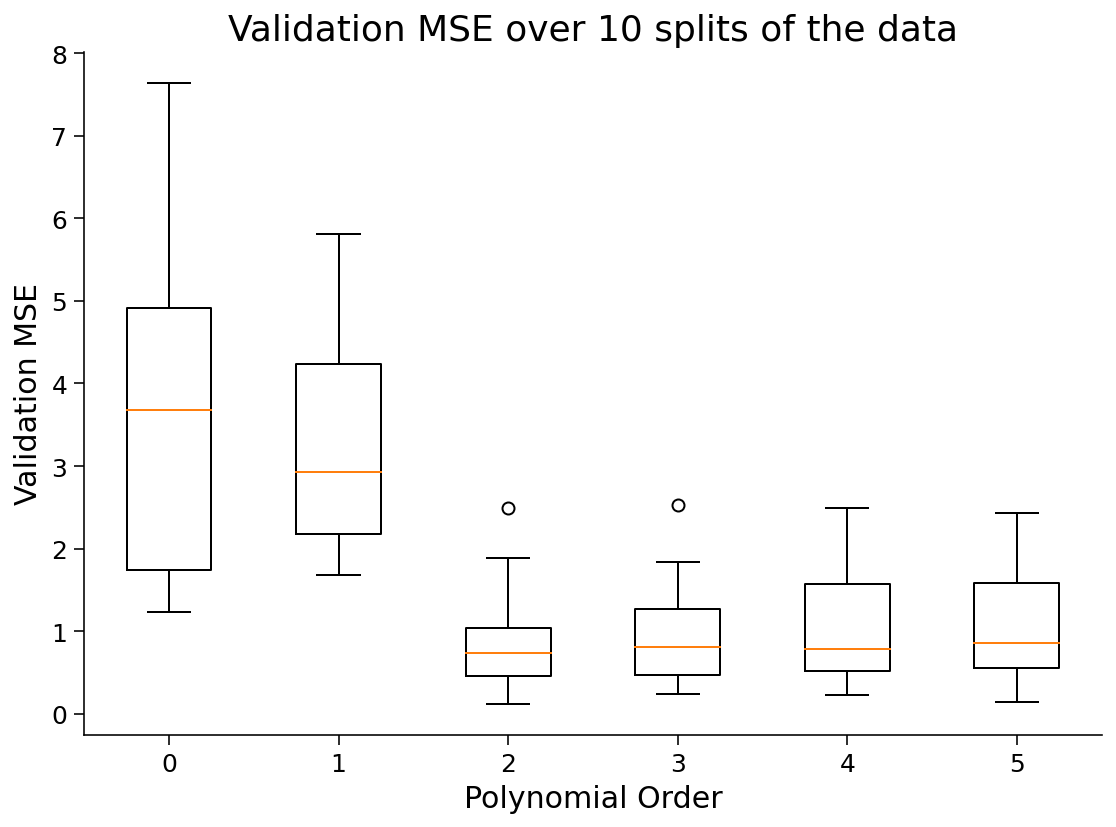

In [18]:
def cross_validate(x_train, y_train, max_order, n_splits):
    """ Compute MSE for k-fold validation for each order polynomial

    Args:
        x_train (ndarray): training data input vector of shape (n_samples)
        y_train (ndarray): training vector of measurements of shape (n_samples)
        max_order (scalar): max order of polynomial fit
        n_split (scalar): number of folds for k-fold validation

    Return:
        ndarray: MSE over splits for each model order, shape (n_splits, max_order + 1)

    """

  # Initialize the split method
    kfold_iterator = KFold(n_splits)

    # Initialize np array mse values for all models for each split
    mse_all = np.zeros((n_splits, max_order + 1))

    for i_split, (train_indices, val_indices) in enumerate(kfold_iterator.split(x_train)):

        # Split up the overall training data into cross-validation training and validation sets
        x_cv_train = x_train[train_indices]
        y_cv_train = y_train[train_indices]
        x_cv_val = x_train[val_indices]
        y_cv_val = y_train[val_indices]

        #############################################################################
        ## TODO for students: Fill in missing ... in code below to choose which data
        ## to fit to and compute MSE for
        # Fill out function and remove
        #raise NotImplementedError("Student exercise: implement cross-validation")
        #############################################################################

        # Fit models
        theta_hats = solve_poly_reg(x_cv_train, y_cv_train, max_order)

        # Compute MSE
        mse_this_split = evaluate_poly_reg(x_cv_val,y_cv_val, theta_hats,max_order)

        mse_all[i_split] = mse_this_split

    return mse_all


# Cross-validate
max_order = 5
n_splits = 10
mse_all = cross_validate(x_train, y_train, max_order, n_splits)

# Visualize
plot_cross_validate_MSE(mse_all)